# Final Project
This dataset comes from a proof-of-concept study published in 1999 by Golub et al. It showed how new cases of cancer could be classified by gene expression monitoring (via DNA microarray) and thereby provided a general approach for identifying new cancer classes and assigning tumors to known classes. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).

There are two datasets containing the training/initial (`training`, 38 samples) and test/independent (`independent`, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood. Intensity values have been re-scaled such that overall intensities for each chip are equivalent.

#### References
Golub, et al.

https://www.science.org/doi/10.1126/science.286.5439.531?url_ver=Z39.88-2003&amp;rfr_id=ori%3Arid%3Acrossref.org&amp;rfr_dat=cr_pub++0pubmed&amp;

Information on data set

https://www.kaggle.com/crawford/gene-expression

## Summary of Gorub, et al.
#### AML-ALL Class Distinction
1. First issue: Explore whether there were genes whose expression pattern was strongly correlated with the class distinction to be predicted
    * Genes are sorted by degree of correlation; correlation determined via "neighborhood analysis": define idealized expression pattern corresponding to one gene which is particularly high in one class and particularly low in another class. Then, test whether there is an unusually high density of genes similar to this idealized pattern, as compared to equivalent random patterns
    * This method was cited as evidence for validating classification based on expression data.
    * **Could this cause overfitting?**
2. Second issue: Using a collection of known samples to create a class predictor capable of assigning a new sample to one of the two classes (ALL or AML)
    * Developed procedure which used a fixed subset of "informative genes", chosen based on their correlation with with class distinction, i.e., how well they predicted the outcome.
        * **Which genes did they choose?**
        * **What was threshold for correlation, i.e., what was cutoff for strength of an informative gene?**
    * Each informative gene casts a weighted vote for one of the classes with the magnitude of each vote depending on degree of expression in new sample and degreee of the gene's correlation with that class
    * Votes are summed to determine prediction strength ($PS$) which ranges from 0 to 1.
    * Sample is assigned to winning class if $PS$ exceeds a predetermined threshold and was otherwise considered uncertain. Threshold used was $PS=0.3$.
3. Third issue: Testing validity of class predictors
    * Used two step-procedure
    * Firstly, accuracy was tested by cross-validation versus training set: withhold a sample from the training set, build a predictor based on remaning samples, use this predictor to determine class of sample initially withheld. Repeat this for all samples
    * Secondly, the final predictor is trained on the training set and then tested on the test set
    
Applied the 3-step approach to the training set. Informative genes chosen as top 50 genes most closely correlated with AML-ALL distinction in the known samples. Parameteres of the predictor were determined by the expression levels of these 50 genes in the known samples. The 50-gene predictor assigned 36 of 38 samples as either ALL or AML and the remaining two as uncertain. All 36 predictions agreed with clinical diagnosis. **Choice to use 50 informative genes in the predictor was somewhat arbitrary --> Determing correlation / Wilcoxon rank sum test to try and determine informative genes. Potential to redefine optimal number of informative genes**

A new 50-gene predictor was created using the 38 samples cited above and this predictor was applied to an independent/test set of 34 leukemia samples. Samples consisted of 24 bone marrow and 10 peripheral blood samples. **Differences in types of samples, bone marrow v. peripheral blood?** In total, predictor made strong predictions for 29 of 34 samples with 100% accuracy compared to clinical diagnosis

Genes most useful in AML-ALL class prediction are strongly related to cell cycle progression, chromatin remodeling, and transcription. Also, some are recognized oncogenes. Some genes are already principle targets of antileukemic drug etoposide. This data suggests that genes useful for cancer prediction may also provide insight into cancer pathogenesis and pharmacology.

#### Cancer Class Discovery
If the AML-ALL class distinction had not already been known, could it have been discovered on the basis of gene expression?
1. First issue: Developing algorithms to clustor tumors by gene expression
    * To cluster tumors they used *self-organizing maps (SOMS)* which is particularly well-suited to the task of identifying a small number of prominent classes in a data set. 
    * User specifies the number of clusters to be identified. SOM finds an optimal set of "centroids" around which data points tend to aggregate. SOM then partitions the data set based on each centroid.
    * SOM was effective yet imperfect at automatically discovering the two types of leukemia
2. Determining whether putative classes produced by such clustering algorithms are meaningful, i.e., whether they reflect true structure in the data rather than simply random aggregation
    * Reasond that class discovery could be tested by class prediction, i.e., if generally accepted class structures reflect true structure, than a class predictor based on these classes should perform well. 
    * Created predictor to assign known samples to either of two classes, A1 or A2. 
    * Predictors that used a wide range of informative genes all performed well in cross-validation
    * Moreover, cross-validation seemed to actually refine the SOM-defined classes such that the assignment of the class predictor were near perfect compared to known samples.
    * Results suggest an iterative procedure for refining clusters in which an SOM is used to initially cluster data, a predictor is constructed, and samples which are not correctly predicted in cross-validation are removed. The edited data set is then used to improve the predictor.
    
Class predictor tested on independent/test set. Generally, predictors for novel classes cannot be assessed for accuracy beecause the "correct" way to classify independent samples is not known. Instead, one must asses whether new samples are assigned a high prediction strength. High prediction strength indicates that tht structure seen in the initial training set is also seen in the test set. Prediction strengths for the class predictor were quite high. To assess statistical significance of results, same analysis was performed with random clustering 

Comparing predictor strength to random clustering strength of prediction, the distinction between classes made by the predictor can be seen as statistically significant and therefore provide evidence for the claim that the AML-ALL class distinction could have been made without any prior biological knowledge.

#### Refining Class Discovery
Class discovery discussed above was extended into trying to determine finer subsets of the leukemias. SOM was used to divide known samples into four clusters. Immunophenotype data was obtained and found that the subclasses largely corresponded to biologically significant classes. Hence, the class discovery refinement afforded further division among the samples along another key biological distinction

#### Takeaways
In principle, the class discovery techniques outlined in the paper could be used to identify fundamental subtypes of any cancer. Such studies will require careful experimental design to avoid potential experimental artifacts. 

Class discovery could also be used to determine cancer mechanisms characteristic to different types of cancers, e.g. combining data for patients with breast cancer and prostate cancer into a single data set and clustering genes based on those that do not correlate with tissue type. 

Class prediction provides an unbiased, general approach to constructing prognostic tests, provided that one has a collection of tumor samples for which eventual outcome is known.

# Importing Data

In [1364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", None, "display.max_columns", None)

# `actual` contains true diagnosis of each patient
df_actual = pd.read_csv("archive/actual.csv")

# `train` is training set used in study
# The first 38 patients/samples are to be used as the training set
# The ROWS of `df_train` are GENES
# The COLUMNS of `df_train` are PATIENTS
df_train = pd.read_csv("archive/data_set_ALL_AML_train.csv")

# `independent` is test data used in study
# The latter 34 patients/samples are to be used as the testing set
# The ROWS of `df_independent` are GENES
# The COLUMNS of `df_independent` are PATIENTS
df_independent = pd.read_csv("archive/data_set_ALL_AML_independent.csv")

df_all = pd.concat([df_train, df_independent], axis=1)

# Recording counts
counts = {"train": {}, "test": {}}

# Counting phenotypes in the training set
ALL_count, AML_count = 0, 0
for index, entry in enumerate(df_actual["cancer"][:38]):
    if entry == "ALL":
        ALL_count += 1
    else:
        AML_count += 1
    
# Appending counts
counts["train"]["ALL"] = ALL_count
counts["train"]["AML"] = AML_count

# Counting phenotypes in the testing set
ALL_count, AML_count = 0, 0
for index, entry in enumerate(df_actual["cancer"][38:]):
    if entry == "ALL":
        ALL_count += 1
    else:
        AML_count += 1
    
# Appending counts
counts["test"]["ALL"] = ALL_count
counts["test"]["AML"] = AML_count

# Printing results
print("Training Set")
print(f"There are {counts['train']['ALL']} occurences of ALL")
print(f"There are {counts['train']['AML']} occurences of AML")
print()
print("Testing Set")
print(f"There are {counts['test']['ALL']} occurences of ALL")
print(f"There are {counts['test']['AML']} occurences of AML")

Training Set
There are 27 occurences of ALL
There are 11 occurences of AML

Testing Set
There are 20 occurences of ALL
There are 14 occurences of AML


In [1365]:
# Here I rename some columns because making plots with some of these 
# Gene descriptors is painful and leads to ugly plots
df_train["Gene Description"].replace({
    "SPTAN1 Spectrin; alpha; non-erythrocytic 1 (alpha-fodrin)": "SPTAN1 Spectrin; alpha", 
    "CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage)": "CST3 Cystatin C",
    "ACADM Acyl-Coenzyme A dehydrogenase; C-4 to C-12 straight chain": "ACADM Acyl-Coenzyme A dehydrogenase",
    "C-myb gene extracted from Human (c-myb) gene; complete primary cds; and five complete alternatively spliced cds":
    "C-myb gene",
    "TCF3 Transcription factor 3 (E2A immunoglobulin enhancer binding factors E12/E47)": "TCF3 Transcription factor 3"
}, inplace=True)

df_train["Gene Description"][759]

'CYSTATIN A'

In [1366]:
# Here we drop the columns "Gene Description" and "Gene Accession Number" to create a new dataframe
# The significance of these genes won't be lost as we can refer back to them using indices later
train = df_train.drop(["Gene Description", "Gene Accession Number"], axis=1)
independent = df_independent.drop(["Gene Description", "Gene Accession Number"], axis=1)
df_all = df_all.drop(["Gene Description", "Gene Accession Number"], axis=1)
df_train["Gene Description"]

0                     AFFX-BioB-5_at (endogenous control)
1                     AFFX-BioB-M_at (endogenous control)
2                     AFFX-BioB-3_at (endogenous control)
3                     AFFX-BioC-5_at (endogenous control)
4                     AFFX-BioC-3_at (endogenous control)
                              ...                        
7124    PTGER3 Prostaglandin E receptor 3 (subtype EP3...
7125    HMG2 High-mobility group (nonhistone chromosom...
7126        RB1 Retinoblastoma 1 (including osteosarcoma)
7127    GB DEF = Glycophorin Sta (type A) exons 3 and ...
7128                            GB DEF = mRNA (clone 1A7)
Name: Gene Description, Length: 7129, dtype: object

In [1367]:
# The "call" columns have three possible values: (P)resent, (A)bsent, or (M)arginal
# The determination of P, A, or M is based on a Wilcoxon rank-sum test, referenced here:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1409797/
# All in all, these call columns will be ignored for the time being
noncalls = [col for col in train.columns if "call" not in col]
train = train[noncalls]
noncalls = [col for col in independent.columns if "call" not in col]
independent = independent[noncalls]

noncalls = [col for col in df_all.columns if "call" not in col]
df_all = df_all[noncalls]

# As a reminder, ROWS --> GENES & COLUMNS --> PATIENTS (array is 7129x38)
df_all

,1,2,3,4,5,6,7,8,9,10,...,54,57,58,60,61,65,66,63,64,62
0,-214,-139,-76,-135,-106,-138,-72,-413,5,-88,...,-90,-137,-157,-172,-47,-62,-58,-161,-48,-176
1,-153,-73,-49,-114,-125,-85,-144,-260,-127,-105,...,-87,-51,-370,-122,-442,-198,-217,-215,-531,-284
2,-58,-1,-307,265,-76,215,238,7,106,42,...,102,-82,-77,38,-21,-5,63,-46,-124,-81
3,88,283,309,12,168,71,55,-2,268,219,...,319,178,340,31,396,141,95,146,431,9
4,-295,-264,-376,-419,-230,-272,-399,-541,-210,-178,...,-283,-135,-438,-201,-351,-256,-191,-172,-496,-294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,793,782,1138,627,250,645,1140,1799,758,570,...,618,507,1372,87,1111,707,423,809,466,551
7125,329,295,777,170,314,341,482,446,385,359,...,308,64,642,98,459,354,41,445,349,194
7126,36,11,41,-50,14,26,10,59,115,9,...,0,-11,-9,-26,-8,-22,0,-2,0,20
7127,191,76,228,126,56,193,369,781,244,171,...,196,198,608,153,73,260,1777,210,284,379


# Preprocessing

In [1368]:
from matplotlib import cm
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize, RobustScaler

# Gonna convert phenotypes to binary representation 0 or 1
# LabelEncoder() does this and keeps track of which of ALL or AML corresponds to 0 or 1
le = LabelEncoder()
df_actual["cancer"] = le.fit_transform(df_actual["cancer"])
actual_train = df_actual[:38]
actual_test = df_actual[38:]

# We just need to make sure to inverse transform in the end using
# df_actual["cancer"] = le.inverse_transform(df_actual["cancer"])

# StandardScaler() standardizes the data by converting gene expression data to their z scores 
# (subtract mean, divide by standard deviation)
# Also, we'll make a new array because fit_transform() converts the data frame to a numpy array
se = StandardScaler()
re = RobustScaler()
scaled_train = pd.DataFrame(re.fit_transform(train))
scaled_independent = pd.DataFrame(re.fit_transform(independent))
scaled_all = pd.DataFrame(re.fit_transform(df_all))

# By transposing the data, we have ROWS --> SAMPLES, COLS --> GENES
# When we do PCA later (the reason for standardizing) this will make it so that the 
# principle components are genes themselves

# I don't know where else to add something like this so I'll add it here
# After much, much deliberation, the color scheme/map I've settled on is "inferno"
cmap = cm.get_cmap("inferno")

# Functions

In [1369]:
def Wilcoxon(dataframe, targets):
    from scipy.stats import ranksums
    """
    Wilcoxon rank-sum test
    Parameters
    ----------
    dataframe = pandas dataframe of feature data (e.g., differentially expressed gene data) 
        (rows x columns = sample x genes)
    targets = pandas dataframe of class labels (in the binary, 0-1 case)
    
    Returns
    -------
    Dictionary of indices sorted by most to least statistically significant
    key:val pairs are gene #:p-val
    """
    r = {} # dictionary of key:val pairs index:p-val
    for i, col in enumerate(dataframe.columns): # For all columns in features data frame
        x, y = [], [] # initialize lists for comparisons
        for val in range(len(dataframe.T.columns)): # 85 is number of patients
            if targets[val] == 1: # Take all gene expression data for prognosis = 1
                x.append(dataframe[col][val]) 
            elif targets[val] == 0: # Take all gene expression data for prognosis = 0
                y.append(dataframe[col][val])
        w, p = ranksums(x, y) # Perform rank-sum test for x and y
        r[col] = p # Append key:val pair to dictionary
    # Sort entries by most statistically significant
    r = dict(sorted(r.items(), key=lambda x: np.abs(x[1]), reverse=False)) 
    return r

def LOOCV(model, X, Y):
    """
    Leave One Out cross validation to evaluate the strength of an estimator.
    Scoring based on balanced accuracy
    
    Params
    ------
    model (estimator) = classification model
    X (pd.DataFrame) = training set
    Y (pd.DataFrame) = training labels
    
    Returns
    -------
    acc_score (float) = 
    """
    from sklearn.metrics import balanced_accuracy_score
    # Firstly, we define the cross val protocol
    # Also, we'll start some lists to keep track of the true labels and the predicted labels
    cv = LeaveOneOut()
    y_true = []
    y_pred = []

    # Loading bar
    loading = "."

    # Proceed by splitting the training data into training and testing sets
    # for each possible splitting within the training set
    # I also got a bit cheeky and added a loading bar cause I'm impatient
    for train_set, test_set in cv.split(X.T):
        # Training and testing sets
        x_train, x_test = X[train_set].T, X[test_set].T
        y_train, y_test = Y["cancer"][train_set], Y["cancer"][test_set]
        # Fit our best random forest to this newly split data
        estimator_val = model.fit(x_train, y_train)
        # evaluate model
        yp = estimator_val.predict(x_test)
        # Save true and predicted labels for scoring later
        y_true.append(np.array(y_test)[0])
        y_pred.append(yp[0])
        # Loading bar. Adds nothing except something to watch as the code runs
        print(loading, end="")

    # Now we can predict the accuracy score
    # Not too bad. Slightly worse than prediction made in training set alone, as to be expected
    acc_score = balanced_accuracy_score(y_pred=y_pred, y_true=y_true)
    print(f"LOOCV Balanced Accuracy Score: {acc_score}")
    
    return acc_score

def CM_display(model, X, Y):
    """
    Displaying confusion matrix given an already fitted estimator as well as
    training data and associated class labels
    Params
    ------
    model (estimator) = classification model
    X (pd.DataFrame) = data set
    Y (pd.DataFrame) = data labels
    
    Returns
    -------
    confusion matrix display
    """
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    # Creating confusion matrix for data set
    model_predicted = model.predict(X.T)

    # Get probabilities for class prediction
    model_CM = confusion_matrix(y_true=Y["cancer"], y_pred=model_predicted)
    model_CM_disp = ConfusionMatrixDisplay(model_CM, display_labels=["ALL", "AML"])

    # Gotta determine some sort of uniform color scheme for these plots still though...
    model_CM_disp.plot(cmap=cmap)
    
    return

def ROC_curve_display(model, X, Y):
    """
    Building an displaying an ROC curve for a given estimator which is already fitted to the training data
    The AUC (area under the curve) is computed and returned (in addition to other things)
    Params
    ------
    model (estimator) = classification model
    X (pd.DataFrame) = array of data
    Y (pd.DataFrame) = array of class labels
    
    Returns
    -------
    """
    from sklearn.metrics import roc_curve, roc_auc_score
    # First we need to predict class probabilities 
    # These are the scores passed to the roc_curve() func to determine fpr, tpr, etc.
    probs = model.predict_proba(X.T)
    good_probs = [p[0] for p in probs]
    
    # roc_curve() outputs a tuple of information that we'll need later
    # fpr = array of false positive rates
    # tpr = array of true positive rates
    # thresh = decreasing thresholds on the decision function
    fpr, tpr, thresh = roc_curve(Y["cancer"], good_probs)
    
    # Here I define the series corresponding to no training at all
    xn = np.linspace(0, 1, 1000)
    yn = xn

    # Plotting
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, lw=2, color=cmap(0.25), alpha=0.7)
    plt.plot(xn, yn, c="k", ls="--", lw=2, alpha=0.5, label="No Training")

    # Computing area under the ROC curve
    areaROC = roc_auc_score(Y["cancer"], good_probs)
    plt.annotate(f"AUC = {areaROC}", xy=(1, 0), ha="right", fontsize=12)

    # Beautification
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(fontsize=12)

    return areaROC

# Messing around with Data

In [1370]:
# Wilcoxon rank-sum test 
# With this we get an idea of the significance of the genes
r = Wilcoxon(train.T, df_actual["cancer"])

In [1371]:
# Create new training data using only the 38 most statistically significant genes
scaled_train_simp = pd.DataFrame().assign(
    ZXY=scaled_train.T[4846],
    CST3=scaled_train.T[1881],
    FAH=scaled_train.T[2019],
    LEPR=scaled_train.T[5038],
    ELA2=scaled_train.T[6217],
    LTC4S=scaled_train.T[3319],
    CSTA=scaled_train.T[759],
    CD33=scaled_train.T[1833],
    LYN=scaled_train.T[1744],
    CHRNA7=scaled_train.T[4498],
    #
    CDC25A=scaled_train.T[2266],
    Cmyb=scaled_train.T[5771],
    APLP2=scaled_train.T[6040],
    CCND3=scaled_train.T[2353],
    ME491=scaled_train.T[4376],
    TCF3=scaled_train.T[6854],
    #
    CTSD=scaled_train.T[2120],
    GLUTATHIONE_S_TRANSFERASE=scaled_train.T[3251],
    ADM=scaled_train.T[247],
    PPBP=scaled_train.T[2014],
    NADPH_flavin=scaled_train.T[311],
    SPTAN1=scaled_train.T[1143],
    #
    Inducible_protein_mRNA=scaled_train.T[1629],
    RETINOBLASTOMA_BINDING_PROTEIN=scaled_train.T[4534],
    MYL1=scaled_train.T[6280],
    NUCLEOLYSIN_TIA_1=scaled_train.T[2232],
    PLECKSTRIN=scaled_train.T[4106],
    Uridine_phosphorylase=scaled_train.T[4779],
    #
    Epb72=scaled_train.T[6538],
    GB_DEF=scaled_train.T[3846],
    INTERLEUKIN_8_PRECURSOR=scaled_train.T[6200],
    Op18=scaled_train.T[1927],
    Thrombospondin_p50=scaled_train.T[2758],
    AFFX_HUMTFRR_M11507_3=scaled_train.T[49],
    #
    Macmarcks=scaled_train.T[803],
    Putative_enterocyte=scaled_train.T[3506],
    PRG1=scaled_train.T[4195],
    PROTEASOME=scaled_train.T[4327],
)

# Create new training data using only the 38 most statistically significant genes
scaled_independent_simp = pd.DataFrame().assign(
    ZXY=scaled_independent.T[4846],
    CST3=scaled_independent.T[1881],
    FAH=scaled_independent.T[2019],
    LEPR=scaled_independent.T[5038],
    ELA2=scaled_independent.T[6217],
    LTC4S=scaled_independent.T[3319],
    CSTA=scaled_independent.T[759],
    CD33=scaled_independent.T[1833],
    LYN=scaled_independent.T[1744],
    CHRNA7=scaled_independent.T[4498],
    #
    CDC25A=scaled_independent.T[2266],
    Cmyb=scaled_independent.T[5771],
    APLP2=scaled_independent.T[6040],
    CCND3=scaled_independent.T[2353],
    ME491=scaled_independent.T[4376],
    TCF3=scaled_independent.T[6854],
    #
    CTSD=scaled_independent.T[2120],
    GLUTATHIONE_S_TRANSFERASE=scaled_independent.T[3251],
    ADM=scaled_independent.T[247],
    PPBP=scaled_independent.T[2014],
    NADPH_flavin=scaled_independent.T[311],
    SPTAN1=scaled_independent.T[1143],
    #
    Inducible_protein_mRNA=scaled_independent.T[1629],
    RETINOBLASTOMA_BINDING_PROTEIN=scaled_independent.T[4534],
    MYL1=scaled_independent.T[6280],
    NUCLEOLYSIN_TIA_1=scaled_independent.T[2232],
    PLECKSTRIN=scaled_independent.T[4106],
    Uridine_phosphorylase=scaled_independent.T[4779],
    #
    Epb72=scaled_independent.T[6538],
    GB_DEF=scaled_independent.T[3846],
    INTERLEUKIN_8_PRECURSOR=scaled_independent.T[6200],
    Op18=scaled_independent.T[1927],
    Thrombospondin_p50=scaled_independent.T[2758],
    AFFX_HUMTFRR_M11507_3=scaled_independent.T[49],
    #
    Macmarcks=scaled_independent.T[803],
    Putative_enterocyte=scaled_independent.T[3506],
    PRG1=scaled_independent.T[4195],
    PROTEASOME=scaled_independent.T[4327],
)

In [1372]:
# Create new training data using only the 38 most statistically significant genes
scaled_train_simp2 = pd.DataFrame().assign(
    ZXY=scaled_train.T[4846],
    CST3=scaled_train.T[1881],
    FAH=scaled_train.T[2019],
    LEPR=scaled_train.T[5038],
    ELA2=scaled_train.T[6217],
    LTC4S=scaled_train.T[3319],
    CSTA=scaled_train.T[759],
    CD33=scaled_train.T[1833],
    LYN=scaled_train.T[1744],
    CHRNA7=scaled_train.T[4498],
)

# Create new training data using only the 38 most statistically significant genes
scaled_independent_simp2 = pd.DataFrame().assign(
    ZXY=scaled_independent.T[4846],
    CST3=scaled_independent.T[1881],
    FAH=scaled_independent.T[2019],
    LEPR=scaled_independent.T[5038],
    ELA2=scaled_independent.T[6217],
    LTC4S=scaled_independent.T[3319],
    CSTA=scaled_independent.T[759],
    CD33=scaled_independent.T[1833],
    LYN=scaled_independent.T[1744],
    CHRNA7=scaled_independent.T[4498],
)

In [1373]:
scaled_train_simp2.T

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
ZXY,0.250000,0.352590,0.205928,1.045283,1.224622,0.330211,-0.154717,-0.606838,-0.624398,0.970075,...,2.145786,7.917785,4.693182,3.003906,3.891182,10.142857,11.871345,3.033684,5.502627,4.820961
CST3,0.258993,2.446215,0.120125,-0.835849,-0.501080,2.487119,-0.692453,-0.661538,0.272873,0.985037,...,3.127563,29.729866,24.928030,2.984375,1.731707,21.366460,28.122807,15.012632,21.338004,5.071325
FAH,0.890288,2.296813,1.730109,1.464151,1.265659,1.370023,1.356604,1.876923,1.052970,1.950125,...,2.956720,2.622483,3.670455,3.164062,3.337711,4.860248,3.867446,3.048421,2.380035,3.672489
LEPR,0.793165,0.412351,0.619345,1.088679,0.816415,0.384075,0.620755,0.938462,0.154093,0.159601,...,2.118451,1.521812,1.761364,4.697266,1.093809,3.770186,1.011696,2.058947,2.297723,1.954876
ELA2,-0.332734,-0.589641,-0.152886,0.060377,0.365011,-0.491803,-0.724528,-0.427350,-0.077047,0.600998,...,0.246014,0.380872,2.750000,1.160156,0.287054,33.217391,4.109162,2.056842,0.385289,5.903930
LTC4S,1.735612,1.856574,1.904836,1.515094,1.688985,1.723653,1.758491,2.611966,1.284109,2.673317,...,4.621868,6.411074,4.554924,4.205078,2.797373,7.649068,7.192982,5.970526,4.168126,1.751092
CSTA,0.003597,0.912351,0.046802,-0.107547,0.412527,0.220141,-0.149057,-0.032479,-0.062600,0.421446,...,1.697039,11.686242,7.026515,2.683594,0.210131,4.611801,18.463938,1.656842,0.336252,1.227074
CD33,0.183453,-0.057769,0.205928,0.281132,0.537797,-0.112412,-0.094340,0.189744,-0.017657,0.159601,...,1.533030,1.385906,0.518939,0.277344,0.311445,1.468944,1.953216,2.591579,1.084063,0.397380
LYN,0.370504,0.984064,-0.107644,1.384906,1.166307,0.459016,0.360377,0.177778,0.171750,0.102244,...,1.428246,4.333893,4.289773,1.271484,0.992495,3.798137,5.001949,1.938947,4.422067,4.443959
CHRNA7,0.266187,0.111554,0.163807,0.618868,0.000000,-0.187354,0.266038,0.675214,0.165329,0.299252,...,1.280182,0.625839,0.393939,0.667969,0.367730,6.975155,1.210526,1.252632,0.642732,0.636099


In [1442]:
# Acquire the indices of the most differentially expressed genes
# Print a dataframe sorted by these genes to get a feel for which genes are 
# indicative of high correlation
most_differentially_expressed = [k for k in r.keys()]
for gene in most_differentially_expressed[:40]:
    print(f"Gene - {gene}")
    print(f"Num. - {df_train['Gene Description'].T[gene]}")
    print()

# This is a list of genes, from most to least differentially expressed
var = df_train.iloc[most_differentially_expressed]["Gene Description"]

# This is a temporary data frame with rows ordered from most to least differentially expressed,
# going from top to bottom
train_sorted = df_train.iloc[most_differentially_expressed]
independent_sorted = independent.iloc[most_differentially_expressed]

# Here we take the same approach as earlier to get rid of the "call" columns in the data frame
# The final product is a clean data frame that we'll use sometime later
noncalls = [col for col in train.columns if "call" not in col]
train_sorted = train_sorted[noncalls]

noncalls = [col for col in independent.columns if "call" not in col]
independent_sorted = independent_sorted[noncalls]

# Again, using the same StandardScaler() used earlier to normalize the data
se = StandardScaler()
scaled_train_sorted = pd.DataFrame(se.fit_transform(train_sorted))
top_50_scaled_frame = scaled_train_sorted[:50]
top_50_scaled_frame

# And this time for the test data
scaled_independent_sorted = pd.DataFrame(se.fit_transform(independent_sorted))
independent_top_50_scaled_frame = scaled_independent_sorted[:50]

Gene - 4846
Num. - Zyxin

Gene - 1881
Num. - CST3 Cystatin C

Gene - 3319
Num. - Leukotriene C4 synthase (LTC4S) gene

Gene - 6217
Num. - ELA2 Elastatse 2; neutrophil

Gene - 759
Num. - CYSTATIN A

Gene - 1833
Num. - CD33 CD33 antigen (differentiation antigen)

Gene - 1744
Num. - LYN V-yes-1 Yamaguchi sarcoma viral related oncogene homolog

Gene - 2019
Num. - FAH Fumarylacetoacetate

Gene - 4498
Num. - CHRNA7 Cholinergic receptor; nicotinic; alpha polypeptide 7

Gene - 5038
Num. - LEPR Leptin receptor

Gene - 2266
Num. - CDC25A Cell division cycle 25A

Gene - 5771
Num. - C-myb gene

Gene - 6040
Num. - APLP2 Amyloid beta (A4) precursor-like protein 2

Gene - 2353
Num. - CCND3 Cyclin D3

Gene - 4376
Num. - ME491  gene extracted from H.sapiens gene for Me491/CD63 antigen

Gene - 6854
Num. - TCF3 Transcription factor 3

Gene - 2120
Num. - CTSD Cathepsin D (lysosomal aspartyl protease)

Gene - 3251
Num. - GLUTATHIONE S-TRANSFERASE; MICROSOMAL

Gene - 247
Num. - ADM Adrenomedullin

Gene - 20

**Zyxin**

Focal adhesions are actin-rich structures that enable cells to adhere to the extracellular matrix and at which protein complexes involved in signal transduction assemble. Zyxin is a zinc-binding phosphoprotein that concentrates at focal adhesions and along the actin cytoskeleton. Zyxin has an N-terminal proline-rich domain and three LIM domains in its C-terminal half. The proline-rich domain may interact with SH3 domains of proteins involved in signal transduction pathways while the LIM domains are likely involved in protein-protein binding. Zyxin may function as a messenger in the signal transduction pathway that mediates adhesion-stimulated changes in gene expression and may modulate the cytoskeletal organization of actin bundles.

**CST3 Cystatin C**

The cystatin superfamily encompasses proteins that contain multiple cystatin-like sequences. Some of the members are active cysteine protease inhibitors, while others have lost or perhaps never acquired this inhibitory activity. There are three inhibitory families in the superfamily, including the type 1 cystatins (stefins), type 2 cystatins and the kininogens. The type 2 cystatin proteins are a class of cysteine proteinase inhibitors found in a variety of human fluids and secretions, where they appear to provide protective functions. This gene is located in the cystatin locus and encodes the most abundant extracellular inhibitor of cysteine proteases, which is found in high concentrations in biological fluids and is expressed in virtually all organs of the body. *A mutation in this gene has been associated with amyloid angiopathy. Expression of this protein in vascular wall smooth muscle cells is severely reduced in both atherosclerotic and aneurysmal aortic lesions, establishing its role in vascular disease. In addition, this protein has been shown to have an antimicrobial function, inhibiting the replication of herpes simplex virus*.

**Leukotriene C4 synthase**

This gene encodes an enzyme that catalyzes the first step in the biosynthesis of cysteinyl leukotrienes, potent biological compounds derived from arachidonic acid. Leukotrienes have been implicated as mediators of anaphylaxis and inflammatory conditions such as human bronchial asthma. This protein localizes to the nuclear envelope and adjacent endoplasmic reticulum.

In [1375]:
from sklearn.feature_selection import mutual_info_classif
# We can perform a similar analysis using the mutual information between each gene and the class label
training_minfo = mutual_info_classif(scaled_train.T, actual_train["cancer"])
# This function returns a (7129,) array of mutual informations between each gene and the class label
# Now we can try and visualize the results!

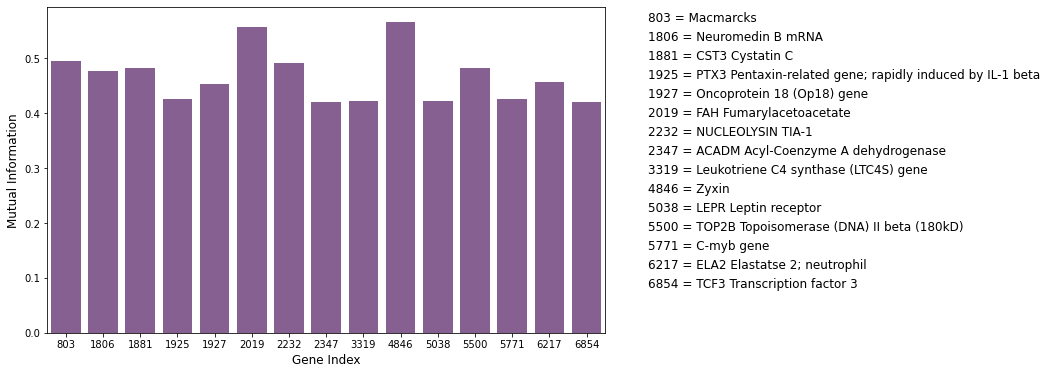

In [1376]:
%matplotlib inline
# Since there are a ton of mutual informations, many of which are insignificant,
# we can institure a cutoff so that only those mutual informations which are meaningful to us 
# are kept
# Of note are the following number of genes above some characteristic thresholds
# 1345 genes with MI > 0.1
# 373 genes with MI > 0.2
# 89 genes with MI > 0.3
# 19 genes with MI > 0.4
# 2 genes with MI > 0.5
mutual_infos = {}
for i,v in enumerate(training_minfo):
    if v > 0.415:
        mutual_infos[i] = v
# Convert the importances array into a dataframe to make plotting easier  
mutual_infos = pd.DataFrame.from_dict(data=mutual_infos, orient="index")

plt.figure(figsize=(10, 6))
X = mutual_infos.T.columns
Y = mutual_infos[0]
sns.barplot(data=mutual_infos, x=X, y=Y, color=cmap(0.25), alpha=0.7)

# Beautification
#plt.title("Mutual Information of Most Informative Genes", fontsize=12)
plt.xlabel("Gene Index", fontsize=12)
plt.ylabel("Mutual Information", fontsize=12)
leg = plt.legend(
    labels = [f"{k} = {df_train['Gene Description'][k]}" for k in X],
    fontsize = 12,
    frameon = False,
    bbox_to_anchor = (1.05, 1),
    loc = 2,
    borderaxespad = 0,
    markerfirst = True,
    handlelength=0,
 )

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/Informative Genes.pdf",
            bbox_extra_artists=(leg,), bbox_inches="tight")

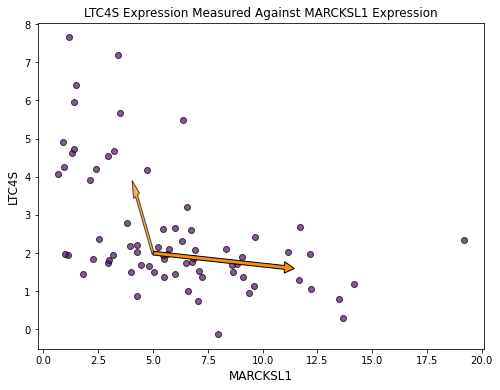

In [1377]:
# As a brief interlude, I'm going to make arrays based on genes genes which appear most often as the most
# differentially expressed or seem to impart the most variability to the data sets for visualization later
# list of genes: 4846, 2019, 1881, 3319 (LTC4S), 803 (MARCKSL1), 1806, 1925, 1927, 2232, 2347, 6854
g4846 = scaled_all.T[4846] # Zyxin
g2019 = scaled_all.T[2019] # Fumarylacetoacetate
g1881 = scaled_all.T[1881] # Cystatine C
g3319 = scaled_all.T[3319] # Leukotriene C4 synthase

X = scaled_all.T[803]
Y = scaled_all.T[3319]
plt.figure(figsize=(8,6))
plt.scatter(X, Y, color=cmap(0.25), alpha=0.7, ec="k", lw=1)
# Arrow
base = (5, 2)
w = 0.1
plt.arrow(x=base[0], y=base[1], dx=6, dy=-.75/2, width=w, color=cmap(0.75), alpha=1, ec="k")
plt.arrow(x=base[0], y=base[1], dx=-0.5*3/2, dy=3/2, width=w, color=cmap(0.75), alpha=0.7, ec="k")

# Beautification
plt.xlabel("MARCKSL1", fontsize=12)
plt.ylabel("LTC4S", fontsize=12)
plt.title("LTC4S Expression Measured Against MARCKSL1 Expression")

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/PCA Example.pdf")

# Principle Component Analysis (PCA)

*Principle Component Analysis* is the process of computing the principle components and using them to perform a change of basis on data. The *principle components* of a collection are the sequence of $n$ unit vectors where the $i$th vector is the direction of a line that best fits the data while being orthogonal to the first $n-1$ vectors. These directions constitute an orthonormal basis in which individual dimensions of the data are linearly uncorrelated.

Importantly, PCA identifies those features with the greatest variance in the dataset. After having identified these features, a smaller dataset (in the sense of dimensionality reduction) can be created with a minimal loss in descriptive power. So, the array of components returned by PCA is *new data*; it has little to do with the original data set. PCA is used, instead, to inform us about those features which contain the most information about some phenotype/class.

In [1378]:
from sklearn.decomposition import PCA

# PCA with "n_components" principle components
# In the case of n_components = 2,
# the array returned by PCA is (7129 x 2) which are (FirstPrincipleComponent x SecondPrincipleComponent)
# ROWS --> per Gene
n_components = 27
pca = PCA(n_components = n_components)
# Fitting PCA to the scaled training data
principle_components = pca.fit_transform(scaled_train)
# The "explained variance ratio" is the proportion of the variance within the data explained by PCA
# If we used all principle components this ratio would be 1
# PCA() by default allows n_components to be all possible components

# The goal of PCA is to reduce the necessary amount of principle components
# So, in an ideal world we would use less than 7000+ principle components (7129 genes in our data set)
print(f"Shape of Original Array       : {scaled_train.shape}")
print(f"Shape of Principle Components : {principle_components.shape}")

# After performing PCA we want to get back the labels of the genes to determine their 
# how much they contribute to that principle direction
# First create a list of indices for each principle component
indices = [f"PC-{i}" for i in range(1, n_components+1)]
# Now we create a new data frame, using 
# ROWS --> Principle Components & COLS --> Genes
# Tranpose the matrix to sort by magnitudes
pca_df = pd.DataFrame(pca.components_, columns=scaled_train.columns, index=indices)
pca_df

Shape of Original Array       : (7129, 38)
Shape of Principle Components : (7129, 27)


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
PC-1,0.130045,0.156013,0.120502,0.142971,0.165415,0.178171,0.141022,0.127485,0.127130,0.190645,...,0.168269,0.132009,0.147718,0.150501,0.144860,0.233661,0.151793,0.161791,0.135865,0.112907
PC-2,-0.007037,0.053310,0.096539,-0.013829,-0.035701,0.321093,0.028074,0.006424,0.088378,0.146319,...,-0.057023,0.231562,0.147165,0.039248,0.024545,-0.019138,0.116353,0.141754,0.077336,0.078249
PC-3,0.032841,0.064807,-0.153286,-0.008741,0.060165,-0.410995,-0.147915,0.003578,-0.063362,-0.206834,...,-0.173677,0.286826,0.286852,0.093981,0.171529,0.109434,0.304163,0.037625,0.108745,0.186697
PC-4,0.022052,-0.187248,-0.141786,0.030001,-0.134847,-0.105705,0.236136,0.108199,-0.329086,-0.274553,...,0.445813,0.009068,-0.007983,0.011692,-0.027120,0.167146,-0.096147,0.055176,-0.010213,0.013447
PC-5,0.228838,0.041592,0.032620,0.141004,0.099153,-0.036887,0.125388,0.167650,0.009755,-0.140737,...,-0.051318,-0.124679,-0.243826,-0.232725,-0.038589,-0.416182,-0.126001,-0.045440,0.015196,-0.112282
PC-6,0.057980,0.139536,0.211487,0.092022,-0.152284,-0.030116,0.264231,0.105551,0.046291,-0.097076,...,0.335903,0.227552,0.018391,-0.051341,0.071244,-0.282019,0.159088,0.072356,0.165736,0.093022
PC-7,-0.005510,0.213128,0.047117,-0.005711,-0.072504,-0.098772,-0.013217,0.105181,0.100267,0.033731,...,-0.198660,-0.300250,-0.016750,0.362496,0.119338,0.062032,-0.205072,-0.182391,-0.014956,0.040193
PC-8,-0.048732,-0.066031,0.034115,0.118118,0.112237,-0.205274,0.006184,-0.066484,0.061701,-0.003709,...,0.232543,-0.320582,-0.124545,0.077133,-0.031927,0.551908,0.004365,0.082652,-0.017702,-0.146869
PC-9,0.045674,-0.104128,-0.080430,0.080782,-0.076719,0.113402,0.058144,0.301204,-0.110391,-0.194714,...,-0.066572,-0.070875,0.312304,0.378905,0.031057,-0.088353,-0.197260,-0.102676,0.039190,0.167696
PC-10,-0.122567,0.146103,-0.104008,-0.011031,-0.049742,0.051275,-0.017376,-0.003513,-0.148832,-0.062710,...,0.144050,-0.110945,-0.063819,-0.053766,0.040477,-0.117983,-0.095704,0.045510,0.147537,0.053401


In [1379]:
# We're interested in reducing the number of principle components 
# Try PCA with a different number of principle components until some threshold is reached
# In this case, the threshold is being able to explain 95% of the variance of the data
threshold = 0.95

# Lists to record the total number of components as well as the number of components required 
# to reach the threshold
num_components = []
total_components = []
for n in range(1, 39):
    # Build PCA model
    pca = PCA(n_components= n)
    pca.fit(scaled_train.T)
    total_components.append(n)
    # Initialize variables for while loop
    total_variance = np.sum(pca.explained_variance_)
    cum_variance = []
    k, current_variance = 0, 0 # k (int) counts the number of features required to reach a certain variance
    while current_variance / total_variance < threshold:
        # Add current explained variance to running total
        current_variance += pca.explained_variance_[k]  
        # Record cumulative proportion of explained variance
        cum_variance.append(current_variance/total_variance) 
        # Increment gene counter by 1
        k += 1
    num_components.append(k)

# Printing results
for ii, n_comps in enumerate(num_components):
    pass
    #print(f"{n_comps}/{total_components[ii]} components explain {100*threshold}% of the variance")

# Building a Predictor

`sklearn.model_selection.GridSearchCV` allows us to perform an exhaustive search over specified parameter values for an estimator. The parameters determined by the function are optimized by a cross-validated grid-search over a parameter grid.

Firstly, I'll use a *random forest classifier* to try and predict classes. A random forest is a collection of decision trees, each of which tries to classify a sample before voting on the final prediction at the very end. Random forests (and decision trees for that matter) offer a lot of flexibility when it comes to altering parameters which affect bias and variance and provide a nice starting point for building a classifier. Also, this classifier within `sklearn` has a `features_importances_` attribute which will allow us to (once again) compare the importance of particular genes to those which have statistical significance determined earlier.

## Random Forest Classifier

In [1380]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# forest_params is passed into the param_grid arg of GridSearchCV 
forest_params = {
    "n_estimators": [60, 70, 80, 90, 100],
    "criterion": ["entropy"],
    "max_features": [0.6, 0.65, 0.7, 0.75, 0.8],
    "min_samples_split": [3, 5, 7],
    "min_samples_leaf": [8, 10, 12, 14],
}

my_forest = RandomForestClassifier(n_estimators=100, min_samples_split=3, min_samples_leaf=8)
# Now we build the GridSearch
# The estimator is chosen to be a random forest
# param_grid is a dictionary of parameters specific to that classifier (refer to docs)
# scoring is the strategy used to evaluate the performance of the cross-validated model on a test set
# scoring methods to consider
# "balanced_accuracy", "top_k_accuracy", "f1", "roc_auc"
forest_search = GridSearchCV(estimator=RandomForestClassifier(),
                             param_grid=forest_params, scoring="f1")

# DO NOT UN-COMMENT THIS. IT TAKES LIKE 20 MINS TO RUN
forest_search.fit(scaled_train.T, df_actual["cancer"][:38])

# Now we have our optimal random forest in `best_forest`
best_forest = forest_search.best_estimator_

In [1381]:
# DO NOT UN-COMMENT THIS. IT TAKES LIKE 20 MINS TO RUN
forest_search.fit(scaled_train_simp.T, actual_train["cancer"])

# Now we have our optimal random forest in `best_forest`
my_best_forest = forest_search.best_estimator_

In [1382]:
# To collect data on this classifier we'll build a dictionary to store information
# Later, this dictionary will be used to build a dataframe
random_forest_dict = {}

In [1383]:
from sklearn.metrics import f1_score
# We'll begin by looking at how good the predictive power of our model is
# Also I'm gonna use bf to represent "best_forest" cause I don't wanna type that out every time
bf_predicted = best_forest.predict(scaled_train.T)
bf_predicted_test = best_forest.predict(scaled_independent.T)
bf_score = best_forest.score(scaled_train.T, actual_train["cancer"]) # This is just 1.0... which is good

# Scoring the "best" random forest
# Scoring metric used is "f1" --> Harmonic mean of precision and recall
random_forest_dict["f1"] = f1_score(actual_test["cancer"], bf_predicted_test)

In [1384]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, balanced_accuracy_score
# Here we perform leave one out cross validation (LOOCV) on the random forest estimator
# Firstly, we define the cross val protocol
# Also, we'll start some lists to keep track of the true labels and the predicted labels
cv = LeaveOneOut()
y_true = []
y_pred = []

# Proceed by splitting the training data into training and testing sets
# for each possible splitting within the training set
# I also got a bit cheeky and added a loading bar cause I'm impatient
for train_set, test_set in cv.split(scaled_train.T):
    # Training and testing sets
    x_train, x_test = scaled_train[train_set].T, scaled_train[test_set].T
    y_train, y_test = actual_train["cancer"][train_set], actual_train["cancer"][test_set]
    # Fit our best random forest to this newly split data
    estimator_val = best_forest.fit(x_train, y_train)
    # evaluate model
    yp = estimator_val.predict(x_test)
    # Save true and predicted labels for scoring later
    y_true.append(np.array(y_test)[0])
    y_pred.append(yp[0])
    # Loading bar. Adds nothing except something to watch as the code runs
    loading = ""
    loading += "."
    print(loading, end="")
    
# Now we can predict the accuracy score
# Not too bad. Slightly worse than prediction made in training set alone, as to be expected
acc_score = balanced_accuracy_score(y_pred=y_pred, y_true=y_true)
print(f"LOOCV Accuracy Score: {acc_score}")

# Reference
# https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

......................................LOOCV Accuracy Score: 0.9090909090909092


In [1429]:
#print(acc_score)

from sklearn.metrics import f1_score

bf_pred_pred = best_forest.predict(scaled_independent.T)
print(balanced_accuracy_score(actual_test["cancer"], bf_pred_pred))

0.5285714285714286


In [1386]:
# Using the LOOCV function I built (scores based on balanced accuracy)
# Gonna keep the code above just for now. Also it measures accuracy, as opposed to balanced accuracy
a = LOOCV(best_forest, scaled_train, actual_train)

......................................LOOCV Balanced Accuracy Score: 0.9545454545454546


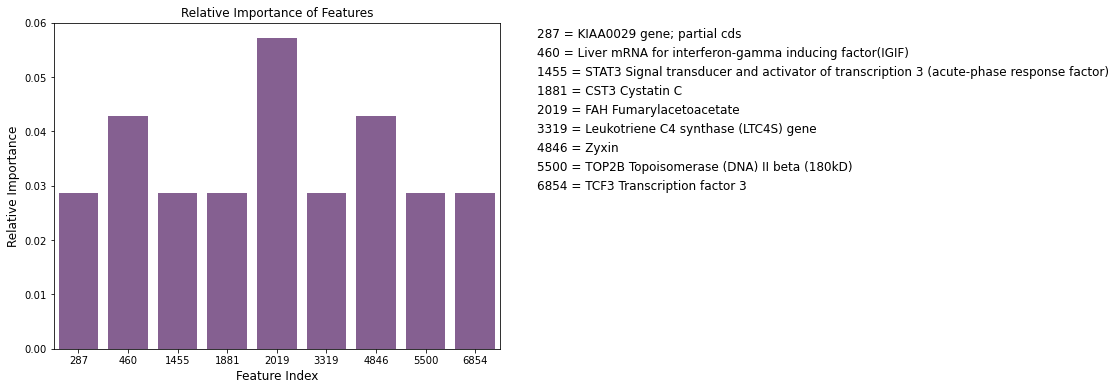

In [1387]:
%matplotlib inline
# Use the feature_importances_ attribute to get the features which contribute most to the forest
# Use these later to visualize
# Iterate through the importance of each gene
# Since most of them are not important, a threshold is set to get only those which are somewhat more important
importances = []
for i,v in enumerate(best_forest.feature_importances_):
    if v > 0.019:
        gene_index = scaled_train.T.columns[i]
        importances.append((gene_index,v))
# Convert the importances array into a dataframe to make plotting easier  
importances = pd.DataFrame(data=importances)
    
# Plotting
plt.figure(figsize=(8,6))
sns.barplot(data=importances, x=importances[0], y=importances[1], color=cmap(0.25), alpha=0.7)

# Beautifying the plot
plt.title("Relative Importance of Features", fontsize=12)
plt.xlabel("Feature Index", fontsize=12)
plt.ylabel("Relative Importance", fontsize=12)
ax = plt.gca()
ax.set_xticklabels(labels=importances[0])

# Trying to make legend look nice 
# Scratch that, succeeding at making the legend look nice
# I ended getting rid of the markers in the legend entirely because linking the
# colors of the bars with the markers of the legend is a pain
# Instead, the legend simply correlates the gene index to an actual gene
genes = [df_train["Gene Description"][gene_index] for gene_index in importances[0]]
gene_nums = importances[0]
leg = plt.legend(
    labels = [f"{gene_nums[k]} = {genes[k]}" for k in range(len(genes))],
    fontsize = 12,
    frameon = False,
    bbox_to_anchor = (1.05, 1),
    loc = 2,
    borderaxespad = 0,
    markerfirst = True,
    handlelength=0,
 )

# Time and time again, Zyxin is the most important/statistically significant of all the genes in our sample
# Additionally, we see that T-COMPLEX-PROTEIN 1; GAMMA SUBUNIT plays an important role in 
# determining the phenotype of a sample

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/Relative Importances.pdf",
           bbox_extra_artists=(leg,), bbox_inches="tight")

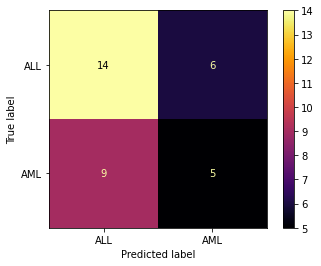

In [1388]:
# Using the confusion matrix display function
# Keeping whats above for funsies
CM_display(best_forest, scaled_independent, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/CM Random Forest testing.pdf")

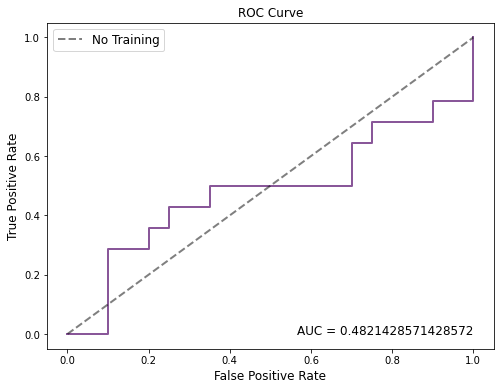

In [1389]:
# Here I'm gonna test the random forest
#best_forest = forest_search.best_estimator_

# Building ROC curve
random_forest_dict["AUC"] = ROC_curve_display(best_forest, scaled_independent, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/ROC Random Forest testing.pdf")

In [1390]:
# We could try testing our random forest on the testing set, after all, it does very well in 
# classification of the training set (as to be expected) and fairly well during cross-validation
# In the interest of getting fancy, being a little creative, or just for the sake of learning, 
# we'll take two different approaches to building up our classifier

# Firstly, the Pipeline Method
# Pipelining in machine learning is automating the workflow by enabling data to be transformed and correlated
# into a model that can then be analyzed to achieve outputs
# In layman's terms, an ML pipeline is an iterative process which is repeated as many times as we please
# to improve the accuracy of a model
# The pipeline itself will consist of a sequence of components/estimators whihc are a compilation of computations
# and predictions
# Importantly, pipelines need not be one-way flows of information. Cyclic pipelines allow iteration to improve 
# the scores of ML algorithms

# Secondly, the Ensemble Method
# Ensemble methods in machine learning is a technique which combines several base models/estimators in order 
# to produce an optimal predictive output. 
# As an example, a random forest is an ensemble method! A random forest is an ensemble of decision trees,
# each of which votes on the final predictive outcome of the model
# Above we've built a random forest model already, so here we'll be interested in building another estimator
# to act in tandem with the random forest

## Nearest Neighbor Classifier

In [1430]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectPercentile, SelectFwe
from sklearn.neighbors import KNeighborsClassifier

# In the beginning of the pipeline we'll go with the tried-and-true K-Nearest Neighbors Model
# I'd like to use the Wilcoxon rank-sum test as the feature selector at least sometimes,
# so I defined a new function which allows us to do that

pipe_NN = Pipeline([
    # First we preprocess/scale the data
    ("Scaler", StandardScaler()), 
    # Finally, classify our features
    ("Classifier", KNeighborsClassifier(n_neighbors= 11, algorithm="ball_tree", leaf_size=1, weights="distance")) 
])

# To collect data on this classifier we'll build a dictionary to store information
# Later, this dictionary will be used to build a dataframe
NN_dict = {}

# Okay so apparently what I have above should just work
pipe_NN.fit(scaled_train.T, actual_train["cancer"])

# Scoring the pipeline on the training set
NN_s_train = pipe_NN.score(scaled_train.T, actual_train["cancer"])
# Scoring the pipeline on the testing set
NN_s_test = pipe_NN.score(scaled_independent.T, actual_test["cancer"])
print("Accuracy")
print(f"Training set: {NN_s_train}")
print(f"Testing set: {NN_s_test}")

NN_predicted = NN.predict(scaled_independent.T)
NN_dict["f1"] = f1_score(actual_test["cancer"], NN_predicted)
print(balanced_accuracy_score(actual_test["cancer"], NN_predicted))

Accuracy
Training set: 1.0
Testing set: 0.6764705882352942
0.5


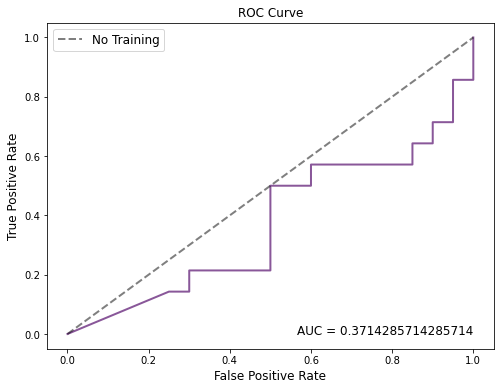

In [1392]:
NN_dict["AUC"] = ROC_curve_display(pipe_NN, scaled_independent, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/ROC kNN testing.pdf")

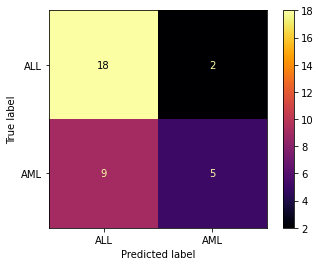

In [1393]:
CM_display(pipe_NN, scaled_independent, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/CM kNN testing.pdf")

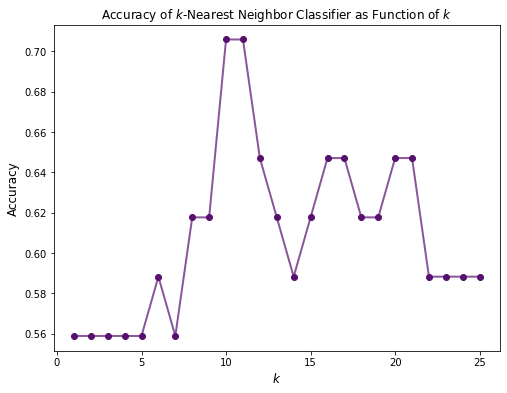

In [1394]:
# Nest, build a k-nearest neighbor classifier of different values for the perecentile
# in the standard scaler and score them
# The fixed number of nearest neighbors will be chosen based on the graph above
K, S_train, S_test = [], [], [] # K = percentile, S_train = train set score, S_test = test set score
scoring_dict = {"K":[], "S_train": [], "S_test": []}
for num in range(1, 26):
    # Storing percentile in list
    K.append(num)
    # Storing percentile in dictionary
    scoring_dict["K"].append(num)
    # Build pipeline
    NN = Pipeline([
        ("Scaler", StandardScaler()), 
        ("Selector", SelectPercentile(percentile = 15)),
        ("Classifier", KNeighborsClassifier(n_neighbors=num)) 
        ])
    # Fit estimator
    NN.fit(scaled_train.T, actual_train["cancer"])
    # Score the estimator on the training set and the testing set
    s_train = NN.score(scaled_train.T, actual_train["cancer"])
    s_test = NN.score(scaled_independent.T, actual_test["cancer"])
    # Storing scores in list
    S_train.append(s_train); S_test.append(s_test)
    # Storing scores in dictionary
    scoring_dict["S_train"].append(s_train)
    scoring_dict["S_test"].append(s_test)
    
# Creating data frame from scoring dictionary
scoring_data = pd.DataFrame(scoring_dict)

# Plotting
plt.figure(figsize=(8,6))

# Line plots and scatter plots of results for both the testing set and training set
#plt.plot(K, S_train, c="r", lw=1)
#plt.scatter(K, S_train, c="r", label="Training")
plt.plot(K, S_test, color=cmap(0.25), alpha=0.7, lw=2)
plt.scatter(K, S_test, color=cmap(0.25), alpha=1, label="Testing")

# Beautification
plt.title(r"Accuracy of $k$-Nearest Neighbor Classifier as Function of $k$", fontsize=12)
plt.xlabel("$k$ ", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

#plt.legend(fontsize=12)

# Ultimately, an iterative process was taken here to optimize the parameters of the nearest neighbor 
# classifier
# The optimal number of neighbors was used to try and find an optimal percentile
# Then, the percentile determined to be best was substituted in the code block above and used to 
# find a new optimal number of neighbors
# This process was repeated until no changes in k or percentile increased the score of the estimator

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/kNN Accuracy Trials.pdf")

<IPython.core.display.Javascript object>


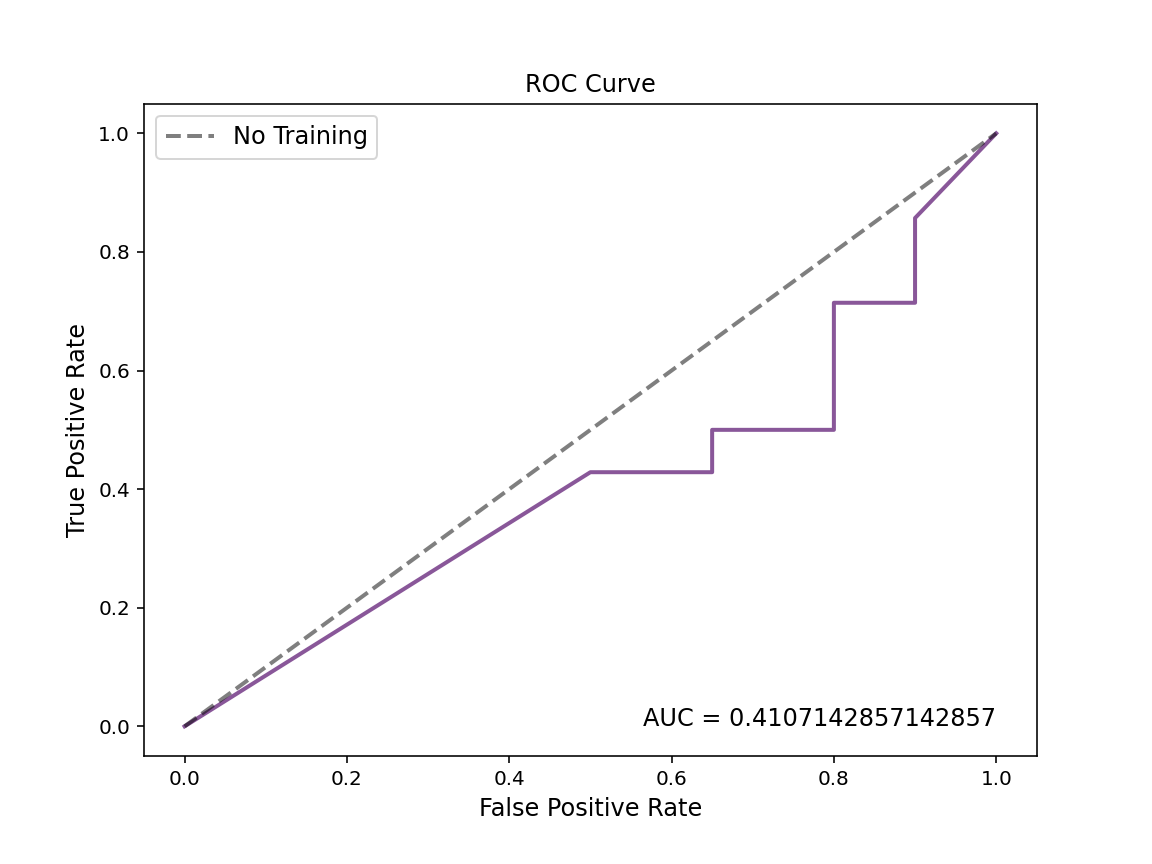

In [1443]:
kNN = KNeighborsClassifier(n_neighbors= 11, algorithm="ball_tree", leaf_size=1, weights="distance")

kNN.fit(scaled_train_simp2, actual_train["cancer"])
kNN_predicted = kNN.predict(scaled_independent_simp2)

pores = f1_score(kNN_predicted, actual_test["cancer"])

ROC_curve_display(kNN, scaled_independent_simp2.T, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/ROC kNN testing simp.pdf")

## Quadratic Discriminant Analysis

In [1432]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Another classifier! 
# Using pipelines again because it makes life easy
pipe_QDA = Pipeline([
    # First we preprocess/scale the data
    ("Scaler", StandardScaler()), 
    # Finally, classify our features
    ("Classifier", QuadraticDiscriminantAnalysis()) 
])

# To collect data on this classifier we'll build a dictionary to store information
# Later, this dictionary will be used to build a dataframe
QDA_dict = {}

# Okay so apparently what I have above should just work
pipe_QDA.fit(scaled_train.T, actual_train["cancer"])

# Scoring the pipeline on the training set
QDA_s_train = pipe_QDA.score(scaled_train.T, actual_train["cancer"])
# Scoring the pipeline on the testing set
QDA_s_test = pipe_QDA.score(scaled_independent.T, actual_test["cancer"])
print("--> Accuracy")
print(f"Training set: {QDA_s_train}")
print(f"Testing set: {QDA_s_test}")

QDA_predicted = QDA.predict(scaled_independent.T)
QDA_dict["f1"] = f1_score(actual_test["cancer"], QDA_predicted)

print(balanced_accuracy_score(actual_test["cancer"], QDA_predicted))

--> Accuracy
Training set: 1.0
Testing set: 0.6176470588235294
0.4892857142857143


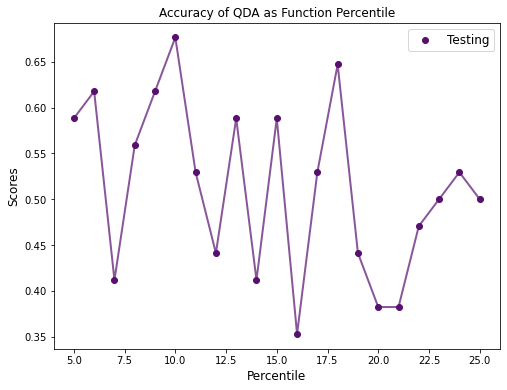

In [1398]:
import warnings
warnings.filterwarnings("ignore")

# K = number of nearest neighbors, S_train = train set score, S_test = test set score
K, S_train, S_test = [], [], [] 
for num in range(5, 26):
    K.append(num)
    # Build pipeline
    QDA = Pipeline([
        ("Scaler", StandardScaler()), 
        ("Selector", SelectPercentile(percentile = num)),
        ("Classifier", QuadraticDiscriminantAnalysis(tol=10**(-5))) 
        ])
    # Fit estimator
    QDA.fit(scaled_train.T, actual_train["cancer"])
    # Score the estimator on the training set and the testing set
    s_train = QDA.score(scaled_train.T, actual_train["cancer"])
    s_test = QDA.score(scaled_independent.T, actual_test["cancer"])
    S_train.append(s_train); S_test.append(s_test)

# Plotting
plt.figure(figsize=(8,6))

# Line plots and scatter plots of results for both the testing set and training set
plt.plot(K, S_test, color=cmap(0.25), alpha=0.7, lw=2)
plt.scatter(K, S_test, color=cmap(0.25), alpha=1, label="Testing")

# Beautification
plt.title(r"Accuracy of QDA as Function Percentile", fontsize=12)
plt.xlabel("Percentile", fontsize=12)
plt.ylabel("Scores", fontsize=12)

plt.legend(fontsize=12)

# In both types of classifiers considered up until this point, the top 10 percentile of genes acts
# as the best source of information for classifying samples

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/QDA Accuracy Trials.pdf")

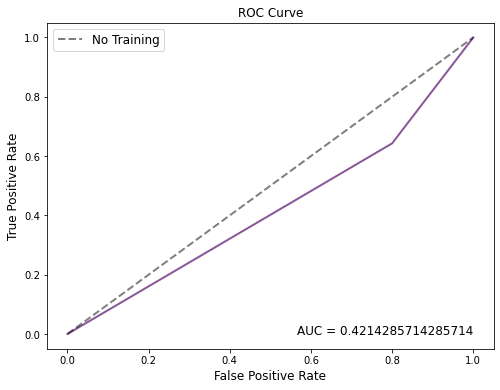

In [1399]:
QDA_dict["AUC"] = ROC_curve_display(pipe_QDA, scaled_independent, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/ROC QDA testing.pdf")

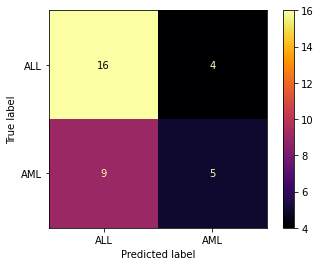

In [1400]:
# Results for the confusion matrix agree with accuracy scores computed initially
CM_display(pipe_QDA, scaled_independent, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/CM QDA testing.pdf")

In [ ]:
CM_display(qda, scaled_independent_simp.T, actual_test)
plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/CM QDA testing.pdf")

# Support Vector Machine

## Linear Support Vector Classification (SVC)

In [ ]:
from sklearn.svm import LinearSVC
# Here we perform leave one out cross validation (LOOCV) on a SVM estimator
lsvc = LinearSVC(penalty="l2", dual=True) 
# Note that `dual` specifies whether the SVM sovles the dual or primal optimization problem

# To collect data on this classifier we'll build a dictionary to store information
# Later, this dictionary will be used to build a dataframe
lsvc_dict = {}

lsvc.fit(scaled_train_simp.T, actual_train["cancer"])

#independent_top_50_scaled_frame 
#top_50_scaled_frame

In [1433]:
# Using the LOOCV function I built (scores based on balanced accuracy)
# Gonna keep the code above just for now
#a = LOOCV(lsvc, scaled_train_simp, actual_train)

# Computing f1 score
lsvc_predicted = lsvc.predict(scaled_independent_simp)
lsvc_dict["f1"] = f1_score(actual_test["cancer"], lsvc_predicted)
print(lsvc_dict["f1"])

print(balanced_accuracy_score(actual_test["cancer"], lsvc_predicted))

0.5
0.575


<IPython.core.display.Javascript object>


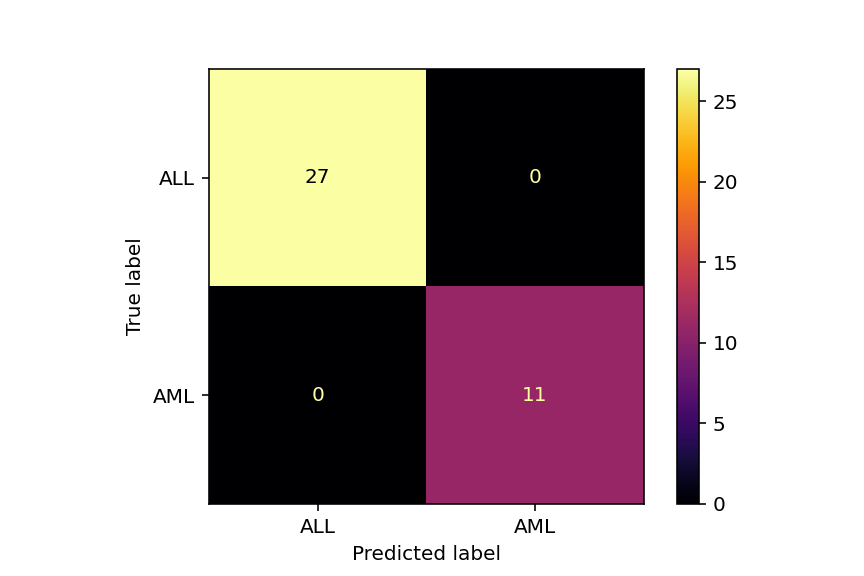

In [1435]:
# Confusion matrix on the training set
CM_display(lsvc, scaled_train_simp.T, actual_train)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/CM LSVC training.pdf")

<IPython.core.display.Javascript object>


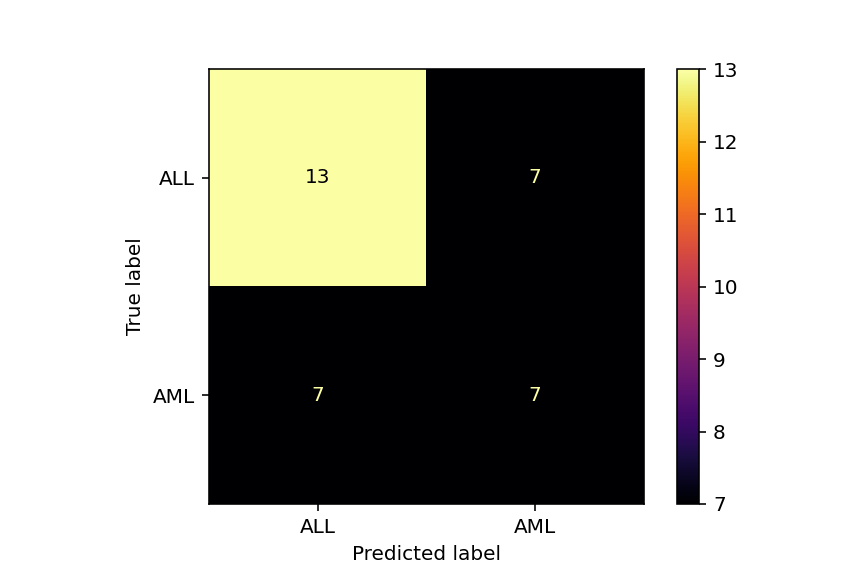

In [1434]:
# The confusion matrix for the testing set does not look as promising
# Though its a little in contrast to the confusion matrix for the kNN
# estimator, as this one predicts AML to be ALL whereas kNN predicts AML to be ALL
CM_display(lsvc, scaled_independent_simp.T, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/CM LSVC testing.pdf")

In [1425]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
# ROC curve for Linear SVC
# LSVC makes our lives more difficult because binary classification with an SVM does not provide any sort 
# of probability estimate for the classes
# So, we need to use CalibratedClassifierCV() to transform the outputs of the classifier into a probability 
# distribution over the classes

# Firstly, build calibrated classifier using Platt scaling
# Cross-validate with LeaveOneOut()
clf = CalibratedClassifierCV(base_estimator=lsvc, method="sigmoid", cv=LeaveOneOut())
clf.fit(scaled_train_simp, actual_train["cancer"])

CalibratedClassifierCV(base_estimator=LinearSVC(), cv=LeaveOneOut())

<IPython.core.display.Javascript object>


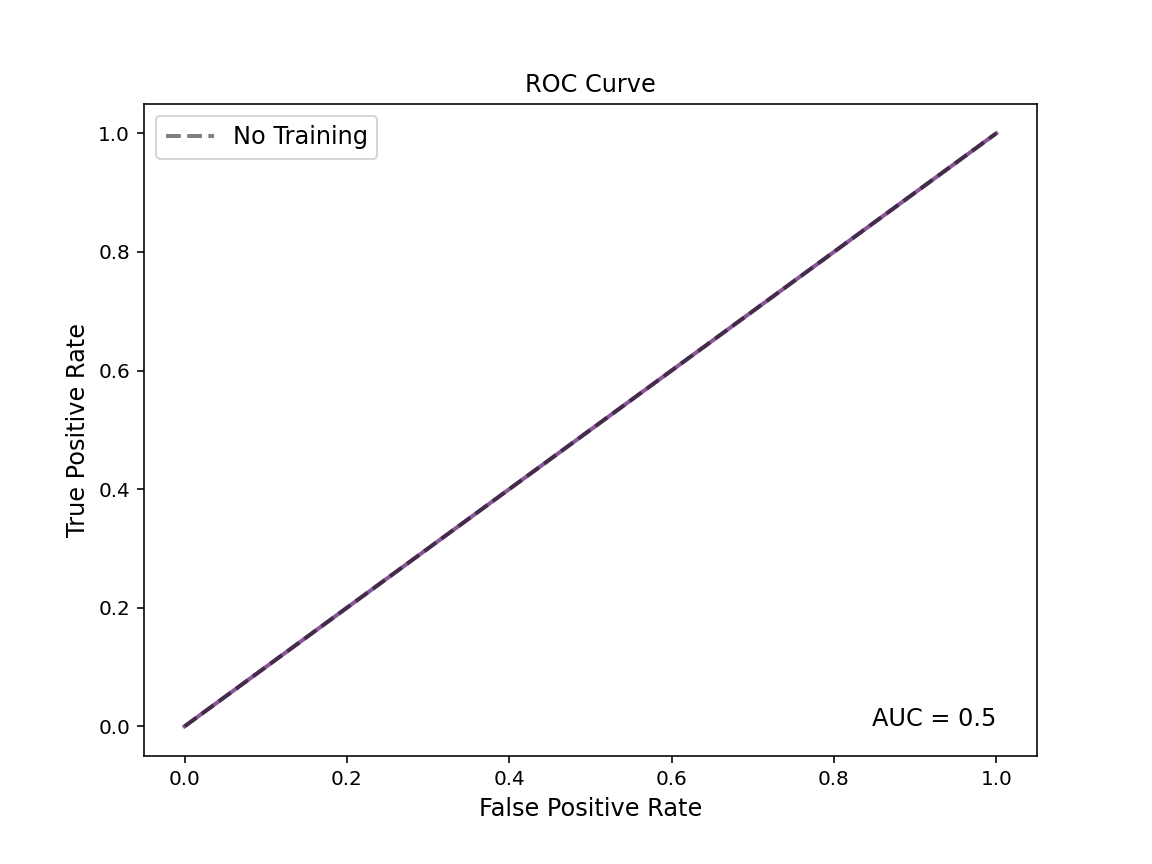

In [1427]:
lsvc_dict["AUC"] = ROC_curve_display(clf, scaled_independent_simp.T, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/ROC Cal LSVC testing.pdf")

In [1402]:
#a = LOOCV(clf, scaled_train, actual_train)
# A cross-val score of 0.5 results in optimal calibration
# This is what we observe!

Gene 3783 vs. Gene 2347


<IPython.core.display.Javascript object>


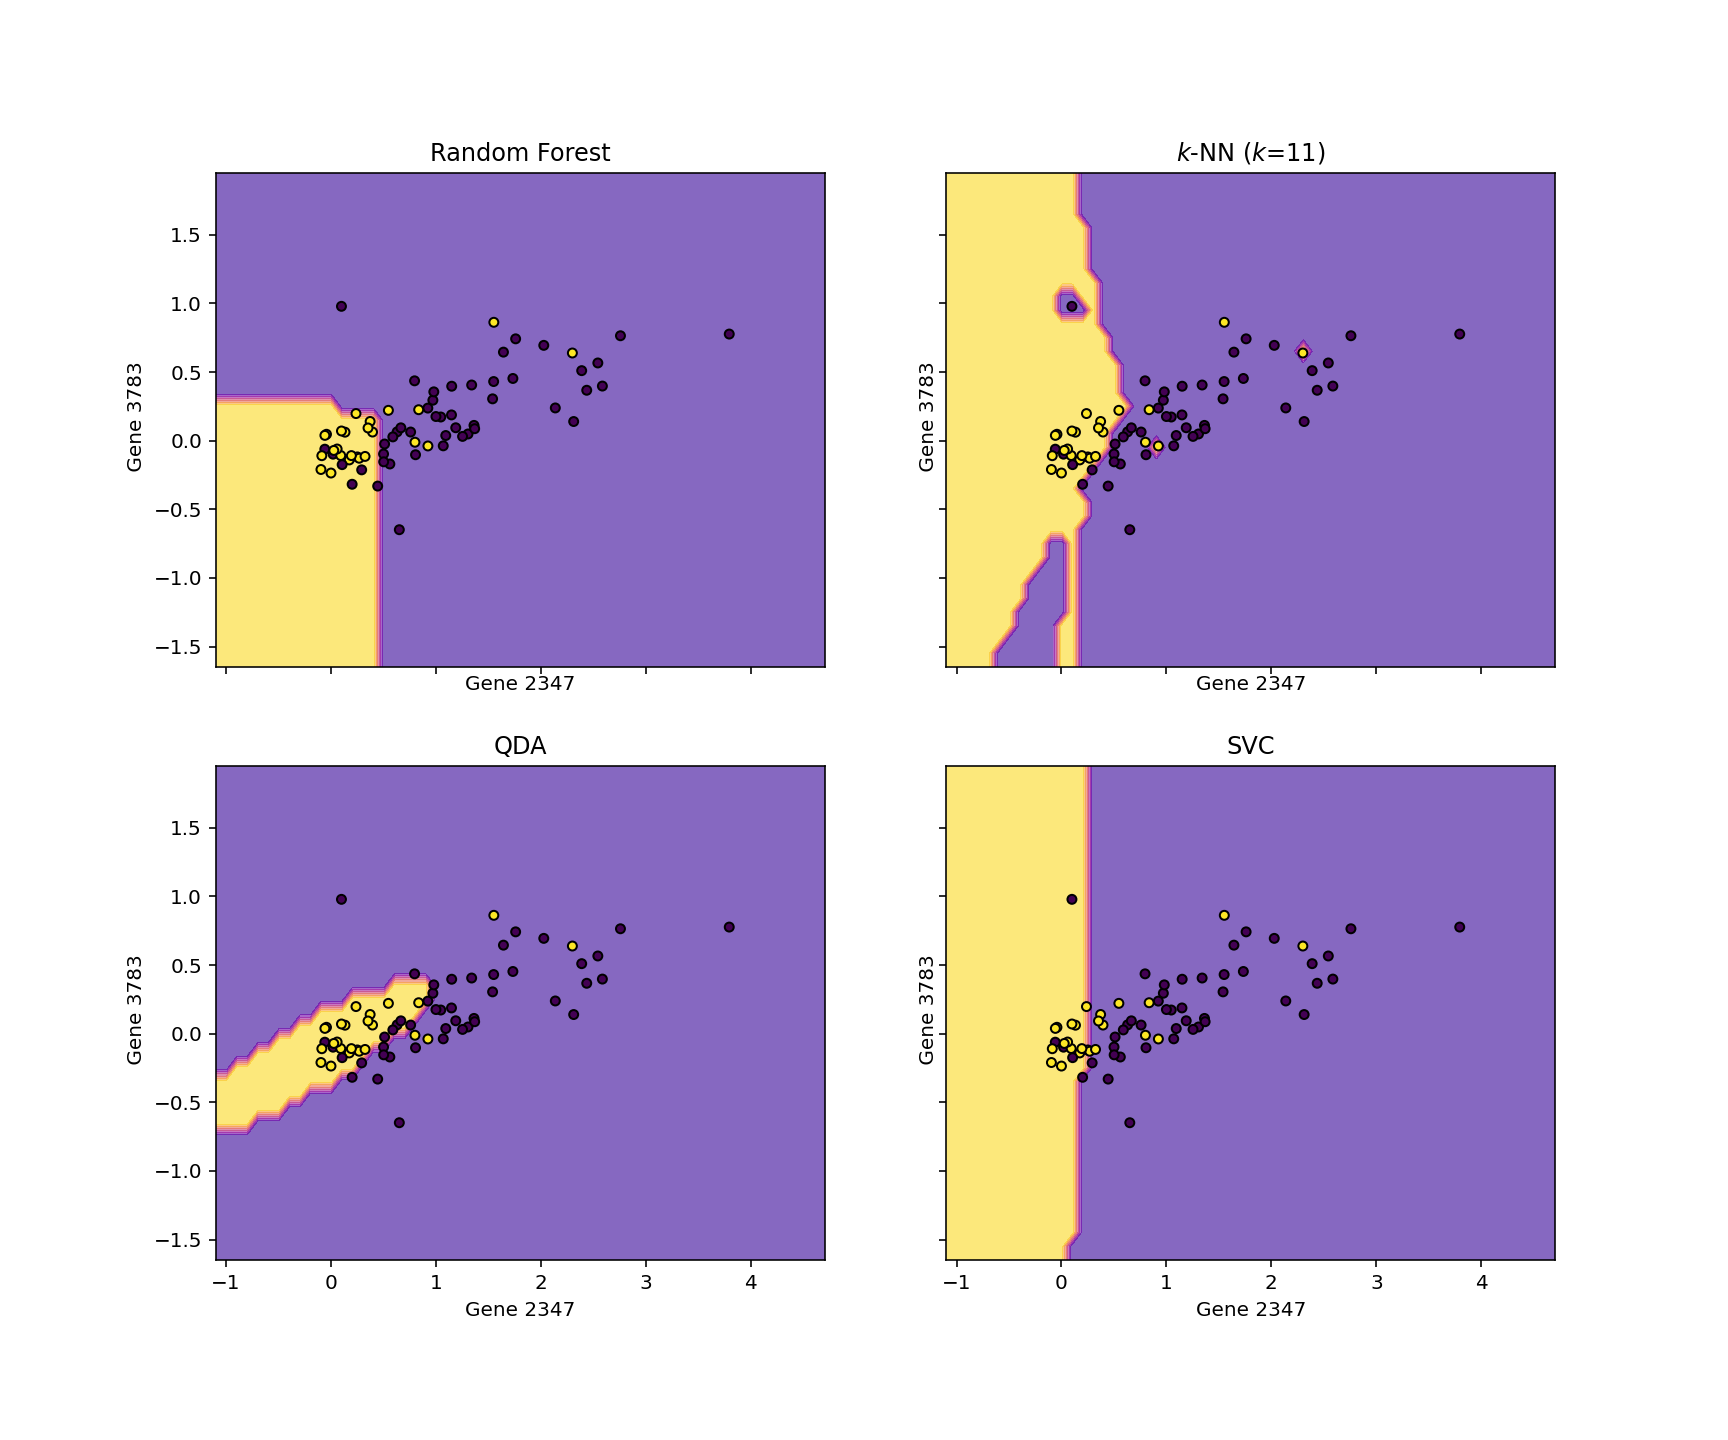

In [1403]:
%matplotlib notebook
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import LinearSegmentedColormap
from random import choice

# Plotting the decision boundary and making a nice picture to make myself feel good :)

# Firstly, I'm going to try and scale the data more robustly
re = RobustScaler()
robust_all = pd.DataFrame(re.fit_transform(df_all))

# Genes of interest (GOI)
# Semi-in order of most to least statistically significant, but not really
# Though, all of these are highly significant, relative to the rest of the data set
GOI = [4846, 2019, 1881, 759, 4545, 2347, 1143, 6040, 6217, 1927, 3319, 3783, 4972, 5771, 6280, 6854, 6894]

# Uncorrelated genes
UG = [6933, 5921, 5537, 5364, 5355]

one = choice(np.hstack([GOI, UG]))
two = choice(np.hstack([GOI, UG]))
#one, two = 1927, 2019
print(f"Gene {two} vs. Gene {one}")

# Good Comparisons
# Gene 2019 vs. Gene 1927

# Choosing some data to consider
X = robust_all.T.iloc[:, [one, two]]
y = df_actual["cancer"]

# Training classifiers

# Firstly, the best random forest we found earlier
clf1 = RandomForestClassifier(criterion='entropy', max_features=0.8,
                       min_samples_leaf=8, min_samples_split=3,
                       n_estimators=70)
# Secondly, a nearest neighbor classifier, using the parameters we used above
clf2 = KNeighborsClassifier(n_neighbors= 11, algorithm="ball_tree", leaf_size=1, weights="distance")
# Thirdly, Quadratic Discriminant analysis
clf3 = QuadraticDiscriminantAnalysis()
# Lastly, a Support Vector Machine for classification
clf4 = SVC(gamma=0.1, kernel="rbf", probability=True)

# Fitting each of the models above
clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
clf4.fit(X, y)

# Plotting decision regions
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(12, 10))

color = plt.cm.viridis(np.linspace(0, 1, 4))

for index, clf, title in zip(
    product([0, 1], [0, 1]),
    [clf1, clf2, clf3, clf4],
    ["Random Forest", r"$k$-NN ($k$=11)", "QDA", "SVC"],
):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax[index[0], index[1]].contourf(xx, yy, Z, alpha=0.6, cmap="plasma")
    ax[index[0], index[1]].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=20, ec="k")
    ax[index[0], index[1]].set_title(title)
    ax[index[0], index[1]].set_xlabel(f"Gene {one}")
    ax[index[0], index[1]].set_ylabel(f" Gene {two}")
    
plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/Decision Boundaries2.pdf")
    
# Source code
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

# Naive Bayes

In [1404]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes classifier
gnb = GaussianNB()

# Fit the classifier
gnb.fit(scaled_train.T, actual_train["cancer"])

# To collect data on this classifier we'll build a dictionary to store information
# Later, this dictionary will be used to build a dataframe
gnb_dict = {}

# Let's see if all of these new functions make my life any easier

In [1405]:
# Cross validaton
#a = LOOCV(gnb, top_50_scaled_frame, actual_train)

# Computing f1 score
gnb_predicted = gnb.predict(scaled_independent.T)
gnb_dict["f1"] = f1_score(actual_test["cancer"], gnb_predicted)

<IPython.core.display.Javascript object>


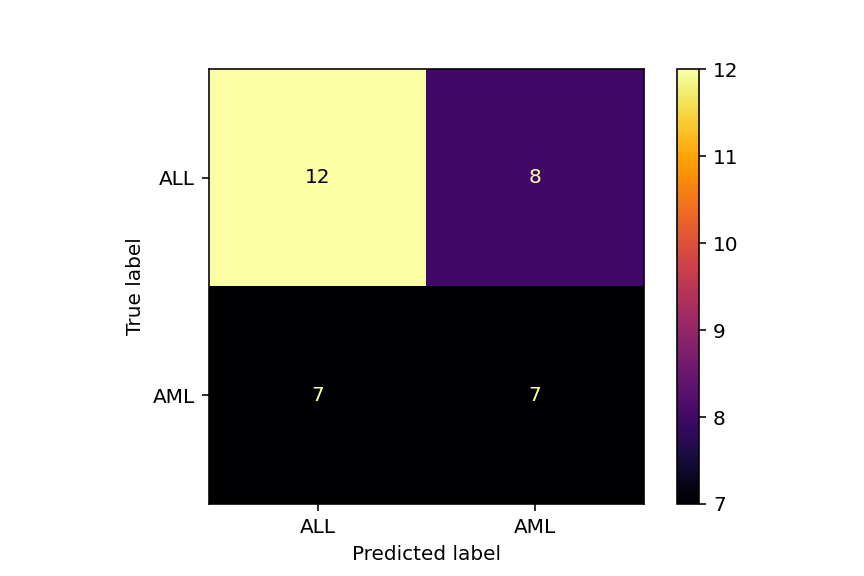

In [1406]:
# Confusion matrix for testing set
CM_display(gnb, scaled_independent, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/CM GNB testing.pdf")
# Eh

<IPython.core.display.Javascript object>


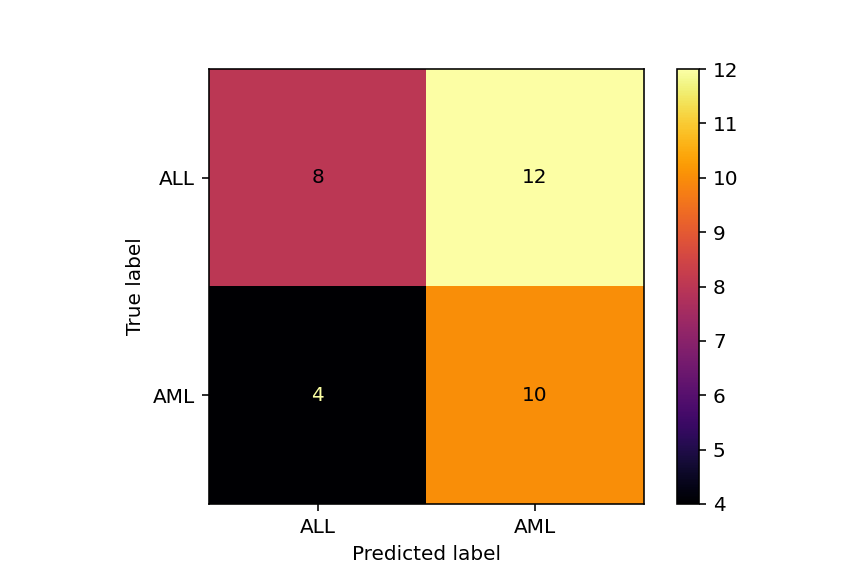

In [1407]:
gnb = GaussianNB()
gnb.fit(scaled_train_simp.T, actual_train["cancer"])
CM_display(gnb, scaled_independent_simp.T, actual_test)

<IPython.core.display.Javascript object>


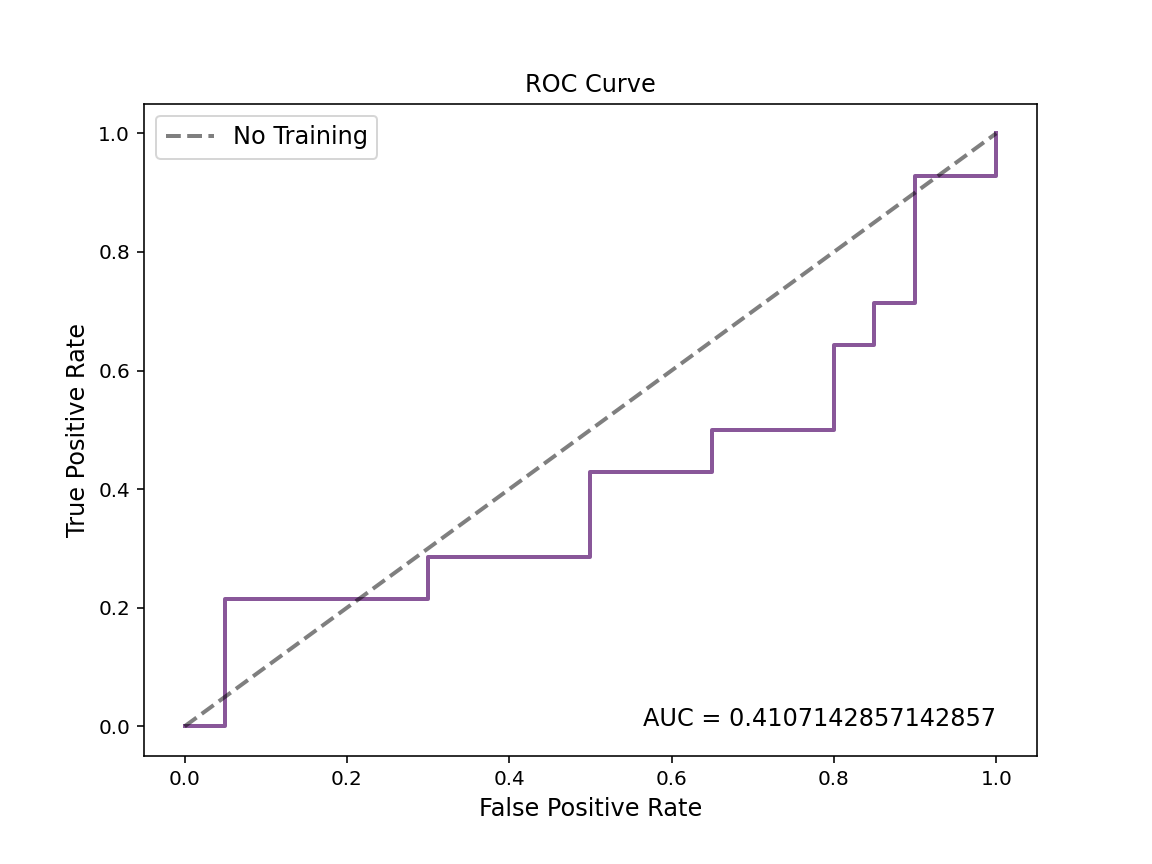

In [1408]:
# ROC Curve
gnb_dict["AUC"] = ROC_curve_display(gnb, scaled_independent_simp.T, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/ROC GNB testing.pdf")
# *exasperated* eh

<IPython.core.display.Javascript object>


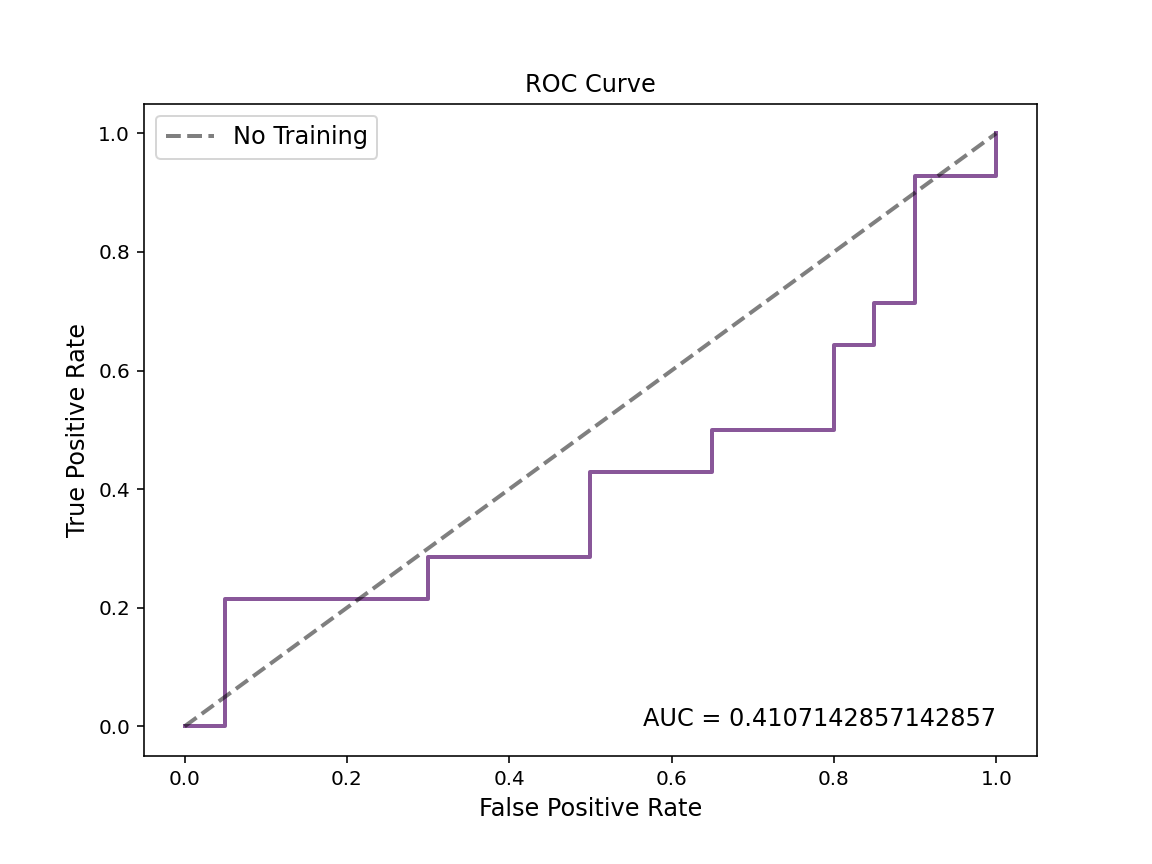

In [1409]:
# ROC Curve
gnb_dict["AUC"] = ROC_curve_display(gnb, scaled_independent_simp.T, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/ROC GNB testing simp.pdf")
# *exasperated* eh

# Voting Classifier

In [1412]:
# Now we'll compile the results from all of our classifiers and create a voting classifier which takes input from
# The most accurate of our classifiers
# Firstly, compile some results from all of our classifiers and present them in a data frame
dict_res = {"Random Forest": random_forest_dict,
           r"$k$ Nearest Neighbors": NN_dict,
           "Quadratic Discriminant Analysis": QDA_dict,
           "Linear SVC": lsvc_dict,
           "Naive Bayes": gnb_dict}

# Compile results into a table
some_res = pd.DataFrame.from_dict(dict_res, orient="index")
display(some_res)

,f1,AUC
Random Forest,0.518519,0.482143
$k$ Nearest Neighbors,0.000000,0.371429
Quadratic Discriminant Analysis,0.413793,0.421429
Linear SVC,0.500000,NaN
Naive Bayes,0.482759,0.410714


In [1440]:
# Above, we see that our most well-performing classifiers are LSVC and QDA (and maybe also kNN)
from sklearn.ensemble import VotingClassifier

# Using only LSVC and QDA for now
#classifiers = [("lsvc", LinearSVC()), ("QDA", QuadraticDiscriminantAnalysis())]
classifiers = [("lsvc", lsvc), ("QDA", pipe_QDA), ("NN", pipe_NN)]
ensemble = VotingClassifier(classifiers, voting="hard")

# Fitting the ensemble classifier
ensemble.fit(scaled_train_simp, actual_train["cancer"])

VotingClassifier(estimators=[('lsvc', LinearSVC()),
                             ('QDA',
                              Pipeline(steps=[('Scaler', StandardScaler()),
                                              ('Classifier',
                                               QuadraticDiscriminantAnalysis())])),
                             ('NN',
                              Pipeline(steps=[('Scaler', StandardScaler()),
                                              ('Classifier',
                                               KNeighborsClassifier(algorithm='ball_tree',
                                                                    leaf_size=1,
                                                                    n_neighbors=11,
                                                                    weights='distance'))]))])

In [1414]:
# LOOCV 
a = LOOCV(ensemble, scaled_train, actual_train)

......................................LOOCV Balanced Accuracy Score: 0.8636363636363636


<IPython.core.display.Javascript object>


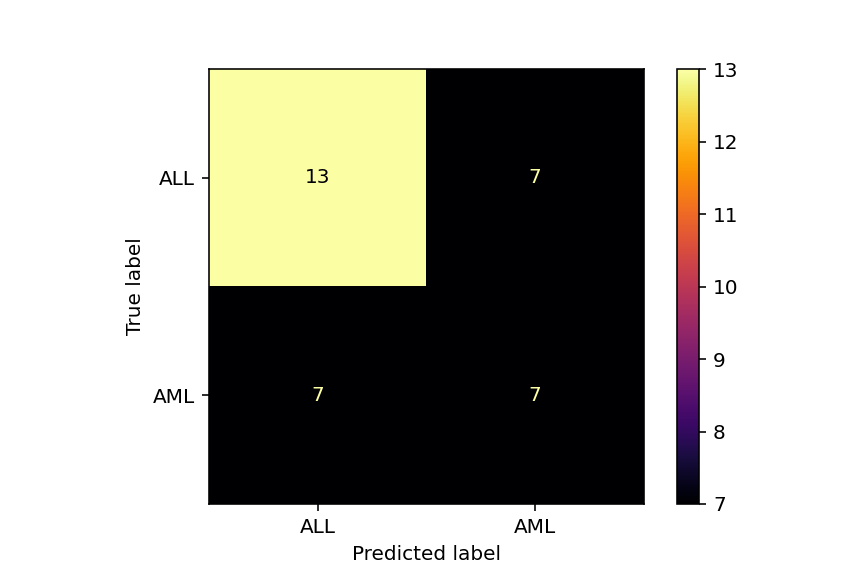

In [1441]:
# Confusion matrix
CM_display(ensemble, scaled_independent_simp.T, actual_test)

plt.savefig("/Users/samdawley/Downloads/LaTeX/CMM/images/CM Ensemble testing.pdf")

In [493]:
from sklearn.calibration import CalibratedClassifierCV
# ROC curve
# "hard" voting will not output probabilities of the class labels for us, making building
# an ROC curve more difficult because we have to compute these probabilities ourselves
#clf = CalibratedClassifierCV(base_estimator=ensemble, method="sigmoid", cv=LeaveOneOut())
#clf.fit(scaled_train.T, actual_train["cancer"])

ensemble_predicted = ensemble.predict(scaled_independent.T)
ensemble_f1 = f1_score(actual_test["cancer"], ensemble_predicted)
ensemble_f1

0.4761904761904762